# Title

## Step 0. Import packages and load data

In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

In [25]:
df_n = pd.read_csv("data/dataproject2025.csv")

In [3]:
df_n.isna().sum()

Unnamed: 0                 0
issue_d                    0
loan duration              0
annual_inc                 0
avg_cur_bal                0
bc_open_to_buy             0
bc_util                    0
delinq_2yrs                0
dti                        0
emp_length                 0
emp_title                  0
fico_range_high            0
funded_amnt                0
grade                      0
home_ownership             0
inq_last_6mths             0
int_rate                   0
mo_sin_old_rev_tl_op       0
mo_sin_rcnt_rev_tl_op      0
mo_sin_rcnt_tl             0
mort_acc                   0
mths_since_recent_bc       0
num_actv_bc_tl             0
num_bc_tl                  0
num_il_tl                  0
num_rev_accts              0
open_acc                   0
pub_rec                    0
pub_rec_bankruptcies       0
purpose                    0
revol_bal                  0
revol_util                 0
sub_grade                  0
target                     0
tax_liens     

In [26]:
df = df_n.dropna()

In [5]:
df.head()

,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


In [6]:
# Check column names and data types
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print(f"\nDataframe shape: {df.shape}")

Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']

Data types:
Unnamed: 0                   int64
issue_d                      int64
loan duration                int64
annual_inc                 float64
avg_cur_bal                float64
bc_open_to_buy             float64
bc_util                    float64
delinq_2yrs                float64
dti                        float64
emp_length                  object
emp_title                  

In [7]:
# profile1 = ProfileReport(df, title="Pandas Profiling Report")

In [8]:
# profile1

In [9]:
for col in df.select_dtypes(include="object").columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 50)

Column: emp_length
['2 years' '10+ years' '5 years' '6 years' '4 years' '3 years' '9 years'
 '8 years' '1 year' '< 1 year' '7 years']
--------------------------------------------------
Column: emp_title
['other' 'sales manager' 'driver' 'operations manager' 'teacher'
 'associate' 'business analyst' 'manager' 'customer service'
 'administrative assistant' 'general manager' 'vice president'
 'supervisor' 'administrator' 'project manager' 'nurse' 'electrician'
 'account manager' 'sales' 'director' 'technician'
 'chief executive officer' 'engineer' 'mechanic' 'truck driver'
 'executive assistant' 'customer service representative'
 'software engineer' 'operator' 'office manager' 'analyst'
 'police officer' 'owner' 'consultant' 'store manager' 'accountant'
 'account executive' 'attorney' 'server' 'financial analyst' 'maintenance'
 'clerk' 'superintendent' 'president' 'program manager'
 'assistant manager' 'machine operator' 'controller' 'paralegal' 'foreman'
 'branch manager']
--------------

## Step 1.

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [28]:
# Prepare data - use original features without manual encoding
X = df.drop(columns=['Unnamed: 0', 'target', 'Predictions', 'Predicted probabilities'])
y = df['Predicted probabilities']

categorical_cols = X.select_dtypes(include='object').columns

le_dict = {}  
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = X[col].fillna("missing")
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

### Surrogate Model1: Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
# keep a final_holdout at first
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X, y, test_size=0.15, random_state=100
)

cv = KFold(n_splits=5, shuffle=True, random_state=100)

param_grid = {
    "max_depth": [4,5,6,8,9],
    "min_samples_leaf": [1,3,5,10,20],
    "min_samples_split": [2,5,8],
    "ccp_alpha": [0.0, 1e-4, 1e-3]
}

In [33]:
dt = DecisionTreeRegressor(random_state=42)
gs = GridSearchCV(dt, param_grid, scoring='r2', cv=cv, n_jobs=-1, return_train_score=True)
gs.fit(X_train_full, y_train_full)

print("Best params:", gs.best_params_)
print("Best CV R2:", gs.best_score_)

Best params: {'ccp_alpha': 0.0, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best CV R2: 0.8939067934521034


In [34]:
# then apply one-standard-error rule
results = pd.DataFrame(gs.cv_results_)

# find best mean test score and correspond std
best_idx = gs.best_index_
best_mean = results.loc[best_idx, 'mean_test_score']
best_std = results.loc[best_idx, 'std_test_score']
print("best mean ± std:", best_mean, best_std)

# one-standard-error rule: find the simpliest model while mean_test_score >= best_mean - best_std
candidates = results[results['mean_test_score'] >= best_mean - best_std]

candidates['param_max_depth'] = candidates['param_max_depth'].astype(float)
simple_choice = candidates.sort_values(['param_max_depth','mean_test_score'], ascending=[True, False]).iloc[0]
print("One-SE chosen params:", simple_choice['params'])

# use one-SE params to train the model，and test on the holdout dataset
final_params = simple_choice['params']  # or gs.best_params_
final_model = DecisionTreeRegressor(random_state=42, **final_params)
final_model.fit(X_train_full, y_train_full)

y_hold_pred = final_model.predict(X_holdout)
print("Holdout R2:", r2_score(y_holdout, y_hold_pred))
print("Holdout MSE:", mean_squared_error(y_holdout, y_hold_pred))

best mean ± std: 0.8939067934521034 0.0006618674207855647
One-SE chosen params: {'ccp_alpha': 0.0, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 2}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28908\979542729.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['param_max_depth'] = candidates['param_max_depth'].astype(float)


Holdout R2: 0.8933091915917111
Holdout MSE: 0.001504983705744826


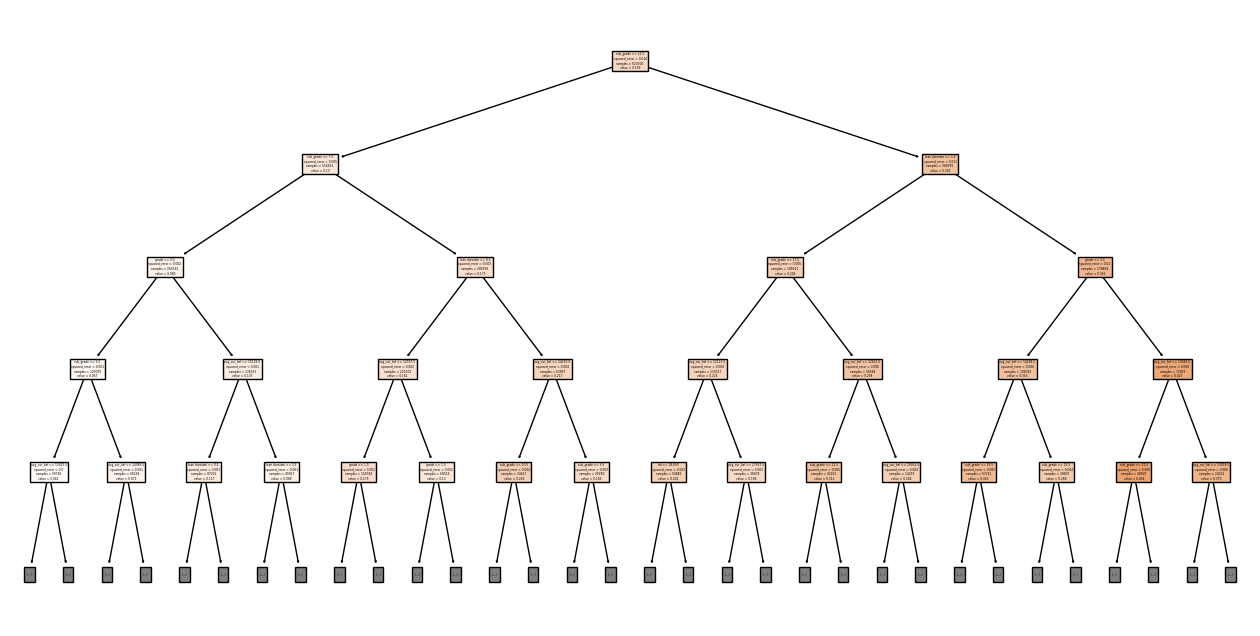

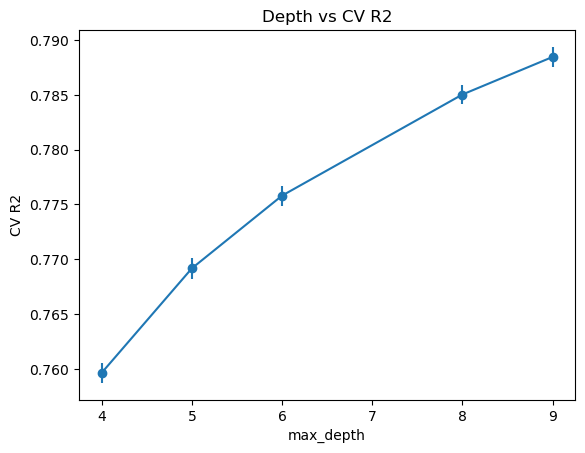

In [35]:
# visulize the decision tree
plt.figure(figsize=(16,8))
plot_tree(final_model, feature_names=X.columns, filled=True, max_depth=4)    # max_depth to keep readable
plt.show()

# max_depth vs CV R2 curve
depth_results = results.groupby('param_max_depth').agg({
    'mean_test_score':'mean', 'std_test_score':'mean'
}).reset_index().sort_values('param_max_depth')
plt.errorbar(depth_results['param_max_depth'], depth_results['mean_test_score'],
             yerr=depth_results['std_test_score'], marker='o')
plt.xlabel('max_depth'); plt.ylabel('CV R2'); plt.title('Depth vs CV R2')
plt.show()

### Surrogate Model2: Linear Regression

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100
)

In [38]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [39]:
# Fidelity 
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

print("Linear Regression Surrogate")
print(f"Train R² = {r2_score(y_train, y_pred_train):.3f}")
print(f"Test  R² = {r2_score(y_test, y_pred_test):.3f}")
print(f"Test  MSE = {mean_squared_error(y_test, y_pred_test):.5f}")

Linear Regression Surrogate
Train R² = 0.934
Test  R² = 0.933
Test  MSE = 0.00094


In [40]:
# interpret coefficients
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": linreg.coef_
})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False)

print("\nTop 10 most influential features:")
print(coef_df.head(10)[["feature","coefficient"]])


Top 10 most influential features:
                 feature  coefficient
1          loan duration     0.081640
13        home_ownership     0.016095
31             sub_grade     0.010641
14        inq_last_6mths     0.007146
26               pub_rec     0.006776
19              mort_acc    -0.005687
12                 grade     0.005657
6            delinq_2yrs     0.004973
27  pub_rec_bankruptcies     0.004966
32             tax_liens    -0.003668


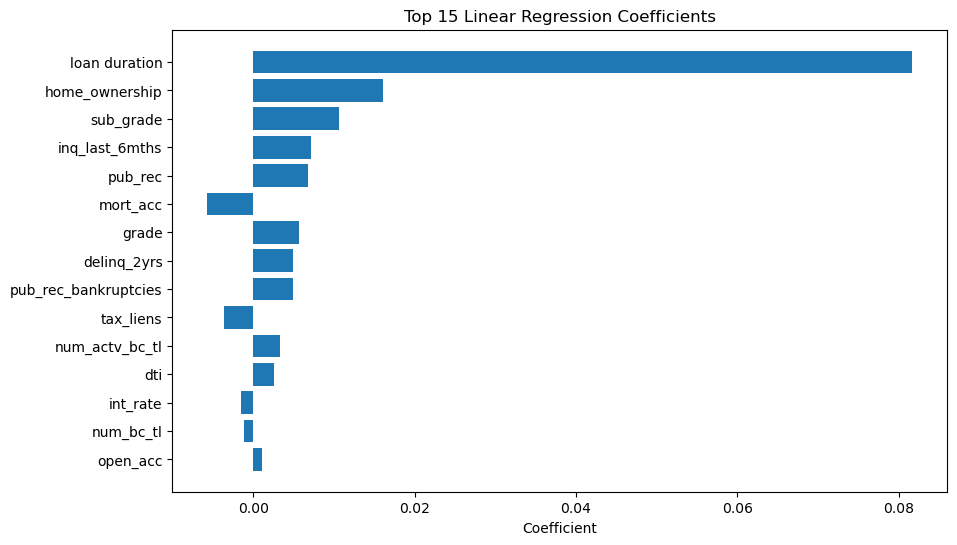

In [41]:
# visulize top 15 coefficients
top_n = 15
plt.figure(figsize=(10,6))
plt.barh(coef_df["feature"].head(top_n), coef_df["coefficient"].head(top_n))
plt.xlabel("Coefficient")
plt.title(f"Top {top_n} Linear Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()

### Takeaway: Comparison of Surrogate Models

- **OLS performs better than Decision Tree**  
  The results show that the relationship between the black-box model’s predicted probabilities and the input features is largely **linear**. In other words, the black-box model does not rely on highly complex nonlinear structures, and a simple linear model can approximate it very well.  

- **Stable generalization with Linear Regression**  
  The train and test R² scores are nearly identical (0.934 vs. 0.933), indicating almost no overfitting. By contrast, the Decision Tree surrogate achieved a lower R² (≈ 0.893), suggesting that it may capture some noise and generalize less effectively.  

- **Interpretability vs. Fidelity**  
  Typically, Decision Trees provide higher fidelity than Linear Regression. However, in this case the opposite holds: **the simplest model (OLS) achieves both higher fidelity and better interpretability**. This is a valuable insight, as it highlights that simpler surrogates can sometimes outperform more complex ones.  

- **Implications for the black-box model**  
  The black-box model itself is likely **close to linear in nature** (e.g., logistic regression, linear probability model, or a nonlinear model with locally linear behavior). Therefore, using OLS as a surrogate not only achieves high fidelity but also provides a clear and intuitive global explanation of the model’s behavior.


## Step 2.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb

# Prepare data - use original features without manual encoding
X = df.drop(columns=['Unnamed: 0', 'target', 'Predictions', 'Predicted probabilities'])
y = df['target']

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution: {y_train.value_counts(normalize=True).round(3).to_dict()}")

Training set: (760365, 35), Test set: (325871, 35)
Class distribution: {0: 0.79, 1: 0.21}


In [ ]:
# ==============================
# Feature lists
# ==============================
ordinal_features = ["emp_length"]
onehot_features = ["home_ownership", "purpose", "emp_title"]

numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# ==============================
# OrdinalEncoder with manual order
# ==============================
emp_length_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
                    "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]

# grade_order = ["A", "B", "C", "D", "E", "F", "G"]

# sub_grade_order = [f"{g}{i}" for g in "ABCDEFG" for i in range(1, 6)]  # A1→G5

ord_encoder = OrdinalEncoder(
    # categories=[emp_length_order, grade_order, sub_grade_order],
    categories=[emp_length_order],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# ==============================
# Construct ColumnTransformer (without using grade and sub_grade)
# ==============================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("ord", ord_encoder, ordinal_features),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_features),
    ]
)

In [27]:
# ==============================
# XGBoost Pipeline
# ==============================
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb.XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
))
])

xgb_pipeline.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_pipeline.predict(X_test)
xgb_pred_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

# Create comparison DataFrame
results_df = pd.DataFrame({
    'Model': ['XGBoost Pipeline'],
    'Accuracy': [xgb_accuracy],
    'AUC Score': [xgb_auc]
})

print(results_df.round(4))

print("\n" + "=" * 70)
print("CLASSIFICATION REPORTS")
print("=" * 70)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

              Model  Accuracy  AUC Score
0  XGBoost Pipeline    0.6561     0.7201

CLASSIFICATION REPORTS

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75    257277
           1       0.34      0.66      0.45     68594

    accuracy                           0.66    325871
   macro avg       0.61      0.66      0.60    325871
weighted avg       0.77      0.66      0.69    325871



In [13]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        solver="lbfgs", 
        max_iter=1000,
        # class_weight="balanced",
        random_state=42
    ))
])

# fit model
logreg_pipeline.fit(X_train, y_train)

# predict
y_pred = logreg_pipeline.predict(X_test)
y_pred_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

# evaluate
print("Logistic Regression - Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Logistic Regression - AUC:", round(roc_auc_score(y_test, y_pred_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Logistic Regression - Accuracy: 0.7922
Logistic Regression - AUC: 0.7071

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88    257277
           1       0.54      0.09      0.15     68594

    accuracy                           0.79    325871
   macro avg       0.67      0.53      0.52    325871
weighted avg       0.75      0.79      0.73    325871



In [14]:
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# =========================
# LightGBM
# =========================
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        # class_weight="balanced",
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_test)
y_proba = lgbm_pipeline.predict_proba(X_test)[:, 1]

print("LightGBM - Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("LightGBM - AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

LightGBM - Accuracy: 0.7949
LightGBM - AUC: 0.7211

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88    257277
           1       0.58      0.09      0.16     68594

    accuracy                           0.79    325871
   macro avg       0.69      0.54      0.52    325871
weighted avg       0.76      0.79      0.73    325871



In [ ]:
# Fast Optuna tuning for LightGBM (optimize ROC-AUC) with scale_pos_weight search
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score

warnings.filterwarnings("ignore")

# Assume you already have: X_train, y_train, X_test, y_test, and `preprocessor` (ColumnTransformer)

# Positive class is 1 (charged-off)
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw_base = max(neg / max(pos, 1), 1.0)  # baseline ~4.0 in your data

def make_lgbm(trial):
    return LGBMClassifier(
        # core hyperparams
        n_estimators      = trial.suggest_int("n_estimators", 300, 1500),
        learning_rate     = trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        num_leaves        = trial.suggest_int("num_leaves", 31, 255),
        max_depth         = trial.suggest_int("max_depth", -1, 12),  # -1 = no limit
        min_child_samples = trial.suggest_int("min_child_samples", 20, 200),
        min_child_weight  = trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
        subsample         = trial.suggest_float("subsample", 0.6, 1.0),         # bagging_fraction
        colsample_bytree  = trial.suggest_float("colsample_bytree", 0.6, 1.0),  # feature_fraction
        reg_alpha         = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        reg_lambda        = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),

        # imbalance handling: tune around baseline with log scale
        scale_pos_weight  = trial.suggest_float("scale_pos_weight", spw_base*0.5, spw_base*2.5, log=True),

        # speed & logging
        bagging_freq      = 1,
        force_row_wise    = True,
        verbose           = -1,
        n_jobs            = -1,
        random_state      = 42,
    )

def objective(trial):
    clf = make_lgbm(trial)
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold for speed
    scores = []

    for tr_idx, va_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # First, fit the pipeline on training data (this fits the preprocessor too)
        pipe.fit(X_tr, y_tr)
        
        # Now make predictions on validation set (pipeline handles preprocessing automatically)
        proba = pipe.predict_proba(X_va)[:, 1]
        
        # Calculate the score (using ROC-AUC as specified in the comment)
        scores.append(roc_auc_score(y_va, proba))

    return float(np.mean(scores))

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=40, gc_after_trial=True)

print("Best value (ROC-AUC):", study.best_value)
print("Best params:", study.best_trial.params)

[I 2025-09-24 14:55:37,316] A new study created in memory with name: no-name-9329a2ac-cc30-43ad-ac30-2fcd42eac177
[I 2025-09-24 14:56:19,364] Trial 0 finished with value: 0.7034694418327123 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682, 'scale_pos_weight': 1.9385085348597748}. Best is trial 0 with value: 0.7034694418327123.
[I 2025-09-24 14:56:19,364] Trial 0 finished with value: 0.7034694418327123 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682, 'sc

Best value (ROC-AUC): 0.7239845633262784
Best params: {'n_estimators': 817, 'learning_rate': 0.023827262282586446, 'num_leaves': 137, 'max_depth': 0, 'min_child_samples': 129, 'min_child_weight': 0.0019962612632129033, 'subsample': 0.6730057056026699, 'colsample_bytree': 0.7087118003155353, 'reg_alpha': 1.7175154779645218e-07, 'reg_lambda': 0.00023819114816827906, 'scale_pos_weight': 2.5985117665334254}
Accuracy: 0.7384486499258909
ROC-AUC: 0.725998193381409
Accuracy: 0.7384486499258909
ROC-AUC: 0.725998193381409
PR-AUC : 0.41454291231839185

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.86      0.80      0.83    257277
charged_off(1)       0.40      0.49      0.44     68594

      accuracy                           0.74    325871
     macro avg       0.63      0.65      0.64    325871
  weighted avg       0.76      0.74      0.75    325871

PR-AUC : 0.41454291231839185

Classification Report:
                 precision    recal

In [ ]:
"""
[I 2025-09-24 14:55:37,316] A new study created in memory with name: no-name-9329a2ac-cc30-43ad-ac30-2fcd42eac177
[I 2025-09-24 14:56:19,364] Trial 0 finished with value: 0.7034694418327123 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682, 'scale_pos_weight': 1.9385085348597748}. Best is trial 0 with value: 0.7034694418327123.
[I 2025-09-24 14:56:19,364] Trial 0 finished with value: 0.7034694418327123 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682, 'scale_pos_weight': 1.9385085348597748}. Best is trial 0 with value: 0.7034694418327123.
[I 2025-09-24 14:56:55,588] Trial 1 finished with value: 0.7147195400346039 and parameters: {'n_estimators': 1464, 'learning_rate': 0.1359792484318226, 'num_leaves': 78, 'max_depth': 1, 'min_child_samples': 53, 'min_child_weight': 0.016480446427978974, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 4.17890272377219e-06, 'reg_lambda': 0.0032112643094417484, 'scale_pos_weight': 2.347371339850552}. Best is trial 1 with value: 0.7147195400346039.
[I 2025-09-24 14:56:55,588] Trial 1 finished with value: 0.7147195400346039 and parameters: {'n_estimators': 1464, 'learning_rate': 0.1359792484318226, 'num_leaves': 78, 'max_depth': 1, 'min_child_samples': 53, 'min_child_weight': 0.016480446427978974, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 4.17890272377219e-06, 'reg_lambda': 0.0032112643094417484, 'scale_pos_weight': 2.347371339850552}. Best is trial 1 with value: 0.7147195400346039.
[I 2025-09-24 14:57:49,763] Trial 2 finished with value: 0.7229364536786945 and parameters: {'n_estimators': 650, 'learning_rate': 0.04649345697900868, 'num_leaves': 133, 'max_depth': 9, 'min_child_samples': 56, 'min_child_weight': 0.11400863701127326, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'reg_alpha': 0.0029369981104377003, 'reg_lambda': 3.425445902633376e-07, 'scale_pos_weight': 2.082326785611213}. Best is trial 2 with value: 0.7229364536786945.
[I 2025-09-24 14:57:49,763] Trial 2 finished with value: 0.7229364536786945 and parameters: {'n_estimators': 650, 'learning_rate': 0.04649345697900868, 'num_leaves': 133, 'max_depth': 9, 'min_child_samples': 56, 'min_child_weight': 0.11400863701127326, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'reg_alpha': 0.0029369981104377003, 'reg_lambda': 3.425445902633376e-07, 'scale_pos_weight': 2.082326785611213}. Best is trial 2 with value: 0.7229364536786945.
[I 2025-09-24 14:58:37,973] Trial 3 finished with value: 0.7211027881148345 and parameters: {'n_estimators': 1439, 'learning_rate': 0.184783006392545, 'num_leaves': 212, 'max_depth': 3, 'min_child_samples': 37, 'min_child_weight': 0.5456725485601477, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'reg_alpha': 0.00028614897264046574, 'reg_lambda': 2.039373116525212e-08, 'scale_pos_weight': 8.103403390220022}. Best is trial 2 with value: 0.7229364536786945.
[I 2025-09-24 14:58:37,973] Trial 3 finished with value: 0.7211027881148345 and parameters: {'n_estimators': 1439, 'learning_rate': 0.184783006392545, 'num_leaves': 212, 'max_depth': 3, 'min_child_samples': 37, 'min_child_weight': 0.5456725485601477, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'reg_alpha': 0.00028614897264046574, 'reg_lambda': 2.039373116525212e-08, 'scale_pos_weight': 8.103403390220022}. Best is trial 2 with value: 0.7229364536786945.
[I 2025-09-24 14:59:07,510] Trial 4 finished with value: 0.7222398996925437 and parameters: {'n_estimators': 610, 'learning_rate': 0.09195011569464331, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 118, 'min_child_weight': 0.0054880470007660455, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483, 'scale_pos_weight': 4.90901008345909}. Best is trial 2 with value: 0.7229364536786945.
[I 2025-09-24 14:59:07,510] Trial 4 finished with value: 0.7222398996925437 and parameters: {'n_estimators': 610, 'learning_rate': 0.09195011569464331, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 118, 'min_child_weight': 0.0054880470007660455, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483, 'scale_pos_weight': 4.90901008345909}. Best is trial 2 with value: 0.7229364536786945.
[I 2025-09-24 15:00:18,026] Trial 5 finished with value: 0.7233949856875551 and parameters: {'n_estimators': 1407, 'learning_rate': 0.024520114718375053, 'num_leaves': 75, 'max_depth': -1, 'min_child_samples': 78, 'min_child_weight': 0.03586816498627549, 'subsample': 0.7085396127095583, 'colsample_bytree': 0.9314950036607718, 'reg_alpha': 1.6247252885719427e-05, 'reg_lambda': 3.376063348877853e-06, 'scale_pos_weight': 4.491672229352795}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:00:18,026] Trial 5 finished with value: 0.7233949856875551 and parameters: {'n_estimators': 1407, 'learning_rate': 0.024520114718375053, 'num_leaves': 75, 'max_depth': -1, 'min_child_samples': 78, 'min_child_weight': 0.03586816498627549, 'subsample': 0.7085396127095583, 'colsample_bytree': 0.9314950036607718, 'reg_alpha': 1.6247252885719427e-05, 'reg_lambda': 3.376063348877853e-06, 'scale_pos_weight': 4.491672229352795}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:00:40,226] Trial 6 finished with value: 0.7180757775612698 and parameters: {'n_estimators': 469, 'learning_rate': 0.1268314555099056, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 159, 'min_child_weight': 0.0062353771356731605, 'subsample': 0.602208846849441, 'colsample_bytree': 0.9261845713819337, 'reg_alpha': 0.022999378190815954, 'reg_lambda': 0.03639690979811287, 'scale_pos_weight': 6.488952737288997}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:00:40,226] Trial 6 finished with value: 0.7180757775612698 and parameters: {'n_estimators': 469, 'learning_rate': 0.1268314555099056, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 159, 'min_child_weight': 0.0062353771356731605, 'subsample': 0.602208846849441, 'colsample_bytree': 0.9261845713819337, 'reg_alpha': 0.022999378190815954, 'reg_lambda': 0.03639690979811287, 'scale_pos_weight': 6.488952737288997}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:01:03,364] Trial 7 finished with value: 0.7226324124756474 and parameters: {'n_estimators': 388, 'learning_rate': 0.04565577551981026, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 132, 'min_child_weight': 0.021066486017042207, 'subsample': 0.6254233401144095, 'colsample_bytree': 0.7243929286862649, 'reg_alpha': 8.445977074223802e-06, 'reg_lambda': 0.036851536911881845, 'scale_pos_weight': 5.232549216207536}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:01:03,364] Trial 7 finished with value: 0.7226324124756474 and parameters: {'n_estimators': 388, 'learning_rate': 0.04565577551981026, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 132, 'min_child_weight': 0.021066486017042207, 'subsample': 0.6254233401144095, 'colsample_bytree': 0.7243929286862649, 'reg_alpha': 8.445977074223802e-06, 'reg_lambda': 0.036851536911881845, 'scale_pos_weight': 5.232549216207536}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:02:08,042] Trial 8 finished with value: 0.7217275384691256 and parameters: {'n_estimators': 1365, 'learning_rate': 0.05932597997400133, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 157, 'min_child_weight': 0.17583640270008521, 'subsample': 0.9083868719818244, 'colsample_bytree': 0.7975182385457563, 'reg_alpha': 0.0005065186776865479, 'reg_lambda': 7.04480806377519e-05, 'scale_pos_weight': 1.9536509843824226}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:02:08,042] Trial 8 finished with value: 0.7217275384691256 and parameters: {'n_estimators': 1365, 'learning_rate': 0.05932597997400133, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 157, 'min_child_weight': 0.17583640270008521, 'subsample': 0.9083868719818244, 'colsample_bytree': 0.7975182385457563, 'reg_alpha': 0.0005065186776865479, 'reg_lambda': 7.04480806377519e-05, 'scale_pos_weight': 1.9536509843824226}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:02:24,688] Trial 9 finished with value: 0.7125292459498193 and parameters: {'n_estimators': 429, 'learning_rate': 0.021501025851126145, 'num_leaves': 174, 'max_depth': 3, 'min_child_samples': 112, 'min_child_weight': 4.268407710065496, 'subsample': 0.69971689165955, 'colsample_bytree': 0.7641531692142519, 'reg_alpha': 0.06308995924905789, 'reg_lambda': 1.1459970229341322e-06, 'scale_pos_weight': 2.1226892538874425}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:02:24,688] Trial 9 finished with value: 0.7125292459498193 and parameters: {'n_estimators': 429, 'learning_rate': 0.021501025851126145, 'num_leaves': 174, 'max_depth': 3, 'min_child_samples': 112, 'min_child_weight': 4.268407710065496, 'subsample': 0.69971689165955, 'colsample_bytree': 0.7641531692142519, 'reg_alpha': 0.06308995924905789, 'reg_lambda': 1.1459970229341322e-06, 'scale_pos_weight': 2.1226892538874425}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:04:48,870] Trial 10 finished with value: 0.7226273107631477 and parameters: {'n_estimators': 1095, 'learning_rate': 0.02027809618076176, 'num_leaves': 249, 'max_depth': -1, 'min_child_samples': 80, 'min_child_weight': 1.450068557874677, 'subsample': 0.7031707810405968, 'colsample_bytree': 0.989976086098868, 'reg_alpha': 3.7840582553041814e-08, 'reg_lambda': 2.6087844118276694e-05, 'scale_pos_weight': 2.946614073587888}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:04:48,870] Trial 10 finished with value: 0.7226273107631477 and parameters: {'n_estimators': 1095, 'learning_rate': 0.02027809618076176, 'num_leaves': 249, 'max_depth': -1, 'min_child_samples': 80, 'min_child_weight': 1.450068557874677, 'subsample': 0.7031707810405968, 'colsample_bytree': 0.989976086098868, 'reg_alpha': 3.7840582553041814e-08, 'reg_lambda': 2.6087844118276694e-05, 'scale_pos_weight': 2.946614073587888}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:05:48,709] Trial 11 finished with value: 0.7231592490118954 and parameters: {'n_estimators': 996, 'learning_rate': 0.03363855307885627, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 80, 'min_child_weight': 0.07512552963695292, 'subsample': 0.8366734543720239, 'colsample_bytree': 0.6031061705825358, 'reg_alpha': 1.8070069505429588e-05, 'reg_lambda': 1.9536858255923362e-07, 'scale_pos_weight': 3.536563216852107}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:05:48,709] Trial 11 finished with value: 0.7231592490118954 and parameters: {'n_estimators': 996, 'learning_rate': 0.03363855307885627, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 80, 'min_child_weight': 0.07512552963695292, 'subsample': 0.8366734543720239, 'colsample_bytree': 0.6031061705825358, 'reg_alpha': 1.8070069505429588e-05, 'reg_lambda': 1.9536858255923362e-07, 'scale_pos_weight': 3.536563216852107}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:06:19,719] Trial 12 finished with value: 0.7220546840419747 and parameters: {'n_estimators': 1057, 'learning_rate': 0.034455611398278, 'num_leaves': 109, 'max_depth': 4, 'min_child_samples': 85, 'min_child_weight': 0.07185611224182759, 'subsample': 0.7447776472653022, 'colsample_bytree': 0.8643422901169147, 'reg_alpha': 3.3622299988277595e-06, 'reg_lambda': 1.8934310003556759e-06, 'scale_pos_weight': 3.465162334078013}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:06:19,719] Trial 12 finished with value: 0.7220546840419747 and parameters: {'n_estimators': 1057, 'learning_rate': 0.034455611398278, 'num_leaves': 109, 'max_depth': 4, 'min_child_samples': 85, 'min_child_weight': 0.07185611224182759, 'subsample': 0.7447776472653022, 'colsample_bytree': 0.8643422901169147, 'reg_alpha': 3.3622299988277595e-06, 'reg_lambda': 1.8934310003556759e-06, 'scale_pos_weight': 3.465162334078013}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:07:41,381] Trial 13 finished with value: 0.7228743937605705 and parameters: {'n_estimators': 1215, 'learning_rate': 0.030470821471338512, 'num_leaves': 149, 'max_depth': 10, 'min_child_samples': 194, 'min_child_weight': 0.053330054408033914, 'subsample': 0.8855765127779958, 'colsample_bytree': 0.855988123872089, 'reg_alpha': 6.30181052766738e-08, 'reg_lambda': 3.219567910488193e-08, 'scale_pos_weight': 3.741819023746293}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:07:41,381] Trial 13 finished with value: 0.7228743937605705 and parameters: {'n_estimators': 1215, 'learning_rate': 0.030470821471338512, 'num_leaves': 149, 'max_depth': 10, 'min_child_samples': 194, 'min_child_weight': 0.053330054408033914, 'subsample': 0.8855765127779958, 'colsample_bytree': 0.855988123872089, 'reg_alpha': 6.30181052766738e-08, 'reg_lambda': 3.219567910488193e-08, 'scale_pos_weight': 3.741819023746293}. Best is trial 5 with value: 0.7233949856875551.
[I 2025-09-24 15:08:36,558] Trial 14 finished with value: 0.7235968812137372 and parameters: {'n_estimators': 893, 'learning_rate': 0.029202686430438888, 'num_leaves': 99, 'max_depth': -1, 'min_child_samples': 80, 'min_child_weight': 0.3645116674004485, 'subsample': 0.7019104689872072, 'colsample_bytree': 0.695710902827807, 'reg_alpha': 7.306601990147998e-07, 'reg_lambda': 8.087111731072225e-06, 'scale_pos_weight': 2.8976537807155442}. Best is trial 14 with value: 0.7235968812137372.
[I 2025-09-24 15:08:36,558] Trial 14 finished with value: 0.7235968812137372 and parameters: {'n_estimators': 893, 'learning_rate': 0.029202686430438888, 'num_leaves': 99, 'max_depth': -1, 'min_child_samples': 80, 'min_child_weight': 0.3645116674004485, 'subsample': 0.7019104689872072, 'colsample_bytree': 0.695710902827807, 'reg_alpha': 7.306601990147998e-07, 'reg_lambda': 8.087111731072225e-06, 'scale_pos_weight': 2.8976537807155442}. Best is trial 14 with value: 0.7235968812137372.
[I 2025-09-24 15:09:24,768] Trial 15 finished with value: 0.7237702344432458 and parameters: {'n_estimators': 818, 'learning_rate': 0.024781109492878046, 'num_leaves': 84, 'max_depth': -1, 'min_child_samples': 93, 'min_child_weight': 0.001206124862574871, 'subsample': 0.6882605144880126, 'colsample_bytree': 0.6984894646761777, 'reg_alpha': 3.3527324007329255e-07, 'reg_lambda': 0.00032391920935964685, 'scale_pos_weight': 2.611934959983495}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:09:24,768] Trial 15 finished with value: 0.7237702344432458 and parameters: {'n_estimators': 818, 'learning_rate': 0.024781109492878046, 'num_leaves': 84, 'max_depth': -1, 'min_child_samples': 93, 'min_child_weight': 0.001206124862574871, 'subsample': 0.6882605144880126, 'colsample_bytree': 0.6984894646761777, 'reg_alpha': 3.3527324007329255e-07, 'reg_lambda': 0.00032391920935964685, 'scale_pos_weight': 2.611934959983495}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:09:43,062] Trial 16 finished with value: 0.7074080928318489 and parameters: {'n_estimators': 868, 'learning_rate': 0.02752294176864902, 'num_leaves': 102, 'max_depth': 1, 'min_child_samples': 26, 'min_child_weight': 0.0013408419153095325, 'subsample': 0.6818367854858786, 'colsample_bytree': 0.6840298337804611, 'reg_alpha': 4.4642468651243895e-07, 'reg_lambda': 0.0007677373858367814, 'scale_pos_weight': 2.715786806954936}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:09:43,062] Trial 16 finished with value: 0.7074080928318489 and parameters: {'n_estimators': 868, 'learning_rate': 0.02752294176864902, 'num_leaves': 102, 'max_depth': 1, 'min_child_samples': 26, 'min_child_weight': 0.0013408419153095325, 'subsample': 0.6818367854858786, 'colsample_bytree': 0.6840298337804611, 'reg_alpha': 4.4642468651243895e-07, 'reg_lambda': 0.0007677373858367814, 'scale_pos_weight': 2.715786806954936}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:10:01,960] Trial 17 finished with value: 0.7121584951830493 and parameters: {'n_estimators': 856, 'learning_rate': 0.07328324549509128, 'num_leaves': 159, 'max_depth': 1, 'min_child_samples': 102, 'min_child_weight': 0.388129330940091, 'subsample': 0.6586677566491509, 'colsample_bytree': 0.7204121973301068, 'reg_alpha': 3.5703134917969363e-07, 'reg_lambda': 3.2763390197575766e-05, 'scale_pos_weight': 2.766555212023902}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:10:01,960] Trial 17 finished with value: 0.7121584951830493 and parameters: {'n_estimators': 856, 'learning_rate': 0.07328324549509128, 'num_leaves': 159, 'max_depth': 1, 'min_child_samples': 102, 'min_child_weight': 0.388129330940091, 'subsample': 0.6586677566491509, 'colsample_bytree': 0.7204121973301068, 'reg_alpha': 3.5703134917969363e-07, 'reg_lambda': 3.2763390197575766e-05, 'scale_pos_weight': 2.766555212023902}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:10:46,682] Trial 18 finished with value: 0.7233979228427533 and parameters: {'n_estimators': 742, 'learning_rate': 0.04202543429566406, 'num_leaves': 96, 'max_depth': -1, 'min_child_samples': 145, 'min_child_weight': 0.0010361978914856119, 'subsample': 0.74505309396069, 'colsample_bytree': 0.6762744002099902, 'reg_alpha': 2.1391295744758306e-08, 'reg_lambda': 6.789187154227627, 'scale_pos_weight': 3.1417007098164174}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:10:46,682] Trial 18 finished with value: 0.7233979228427533 and parameters: {'n_estimators': 742, 'learning_rate': 0.04202543429566406, 'num_leaves': 96, 'max_depth': -1, 'min_child_samples': 145, 'min_child_weight': 0.0010361978914856119, 'subsample': 0.74505309396069, 'colsample_bytree': 0.6762744002099902, 'reg_alpha': 2.1391295744758306e-08, 'reg_lambda': 6.789187154227627, 'scale_pos_weight': 3.1417007098164174}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:11:14,234] Trial 19 finished with value: 0.719667897539138 and parameters: {'n_estimators': 1231, 'learning_rate': 0.06612564330092856, 'num_leaves': 37, 'max_depth': 2, 'min_child_samples': 97, 'min_child_weight': 6.288045645965098, 'subsample': 0.7466620110710483, 'colsample_bytree': 0.7200818236420318, 'reg_alpha': 8.176128844057752e-07, 'reg_lambda': 0.0004233356331424625, 'scale_pos_weight': 2.4762679925256736}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:11:14,234] Trial 19 finished with value: 0.719667897539138 and parameters: {'n_estimators': 1231, 'learning_rate': 0.06612564330092856, 'num_leaves': 37, 'max_depth': 2, 'min_child_samples': 97, 'min_child_weight': 6.288045645965098, 'subsample': 0.7466620110710483, 'colsample_bytree': 0.7200818236420318, 'reg_alpha': 8.176128844057752e-07, 'reg_lambda': 0.0004233356331424625, 'scale_pos_weight': 2.4762679925256736}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:11:46,299] Trial 20 finished with value: 0.7228185473257281 and parameters: {'n_estimators': 952, 'learning_rate': 0.036140962012433116, 'num_leaves': 75, 'max_depth': 5, 'min_child_samples': 63, 'min_child_weight': 1.8142508352390574, 'subsample': 0.6595417181997795, 'colsample_bytree': 0.8310365866154781, 'reg_alpha': 5.0183892563050593e-05, 'reg_lambda': 0.003546308440112934, 'scale_pos_weight': 9.366038516003421}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:11:46,299] Trial 20 finished with value: 0.7228185473257281 and parameters: {'n_estimators': 952, 'learning_rate': 0.036140962012433116, 'num_leaves': 75, 'max_depth': 5, 'min_child_samples': 63, 'min_child_weight': 1.8142508352390574, 'subsample': 0.6595417181997795, 'colsample_bytree': 0.8310365866154781, 'reg_alpha': 5.0183892563050593e-05, 'reg_lambda': 0.003546308440112934, 'scale_pos_weight': 9.366038516003421}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:12:35,721] Trial 21 finished with value: 0.7228776085834591 and parameters: {'n_estimators': 769, 'learning_rate': 0.04389167488608874, 'num_leaves': 115, 'max_depth': -1, 'min_child_samples': 136, 'min_child_weight': 0.0012345181757780583, 'subsample': 0.7467310163464405, 'colsample_bytree': 0.6749576144096379, 'reg_alpha': 1.884831747671162e-08, 'reg_lambda': 7.9494579367851665, 'scale_pos_weight': 3.0254307406860503}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:12:35,721] Trial 21 finished with value: 0.7228776085834591 and parameters: {'n_estimators': 769, 'learning_rate': 0.04389167488608874, 'num_leaves': 115, 'max_depth': -1, 'min_child_samples': 136, 'min_child_weight': 0.0012345181757780583, 'subsample': 0.7467310163464405, 'colsample_bytree': 0.6749576144096379, 'reg_alpha': 1.884831747671162e-08, 'reg_lambda': 7.9494579367851665, 'scale_pos_weight': 3.0254307406860503}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:13:15,993] Trial 22 finished with value: 0.7235675728732591 and parameters: {'n_estimators': 596, 'learning_rate': 0.02656877316071726, 'num_leaves': 90, 'max_depth': -1, 'min_child_samples': 160, 'min_child_weight': 0.0030164845207920573, 'subsample': 0.7372233553360793, 'colsample_bytree': 0.6584446094768356, 'reg_alpha': 1.0171499966362424e-08, 'reg_lambda': 0.38539717547369756, 'scale_pos_weight': 3.236208583267246}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:13:15,993] Trial 22 finished with value: 0.7235675728732591 and parameters: {'n_estimators': 596, 'learning_rate': 0.02656877316071726, 'num_leaves': 90, 'max_depth': -1, 'min_child_samples': 160, 'min_child_weight': 0.0030164845207920573, 'subsample': 0.7372233553360793, 'colsample_bytree': 0.6584446094768356, 'reg_alpha': 1.0171499966362424e-08, 'reg_lambda': 0.38539717547369756, 'scale_pos_weight': 3.236208583267246}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:13:52,542] Trial 23 finished with value: 0.7230668523943194 and parameters: {'n_estimators': 516, 'learning_rate': 0.024666947284576374, 'num_leaves': 83, 'max_depth': 0, 'min_child_samples': 195, 'min_child_weight': 0.0031514068195633155, 'subsample': 0.7978849708136373, 'colsample_bytree': 0.6320390812432972, 'reg_alpha': 1.7937595304624982e-07, 'reg_lambda': 0.26068374737427763, 'scale_pos_weight': 4.070102683720079}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:13:52,542] Trial 23 finished with value: 0.7230668523943194 and parameters: {'n_estimators': 516, 'learning_rate': 0.024666947284576374, 'num_leaves': 83, 'max_depth': 0, 'min_child_samples': 195, 'min_child_weight': 0.0031514068195633155, 'subsample': 0.7978849708136373, 'colsample_bytree': 0.6320390812432972, 'reg_alpha': 1.7937595304624982e-07, 'reg_lambda': 0.26068374737427763, 'scale_pos_weight': 4.070102683720079}. Best is trial 15 with value: 0.7237702344432458.
[I 2025-09-24 15:14:40,629] Trial 24 finished with value: 0.7237835757882606 and parameters: {'n_estimators': 582, 'learning_rate': 0.026972612727840115, 'num_leaves': 121, 'max_depth': 0, 'min_child_samples': 172, 'min_child_weight': 0.013918875920239418, 'subsample': 0.6587955242698611, 'colsample_bytree': 0.7487823167070415, 'reg_alpha': 1.2755174226834844e-08, 'reg_lambda': 1.0192709109798924e-05, 'scale_pos_weight': 2.378743301840043}. Best is trial 24 with value: 0.7237835757882606.
[I 2025-09-24 15:14:40,629] Trial 24 finished with value: 0.7237835757882606 and parameters: {'n_estimators': 582, 'learning_rate': 0.026972612727840115, 'num_leaves': 121, 'max_depth': 0, 'min_child_samples': 172, 'min_child_weight': 0.013918875920239418, 'subsample': 0.6587955242698611, 'colsample_bytree': 0.7487823167070415, 'reg_alpha': 1.2755174226834844e-08, 'reg_lambda': 1.0192709109798924e-05, 'scale_pos_weight': 2.378743301840043}. Best is trial 24 with value: 0.7237835757882606.
[I 2025-09-24 15:14:52,623] Trial 25 finished with value: 0.7125652958781364 and parameters: {'n_estimators': 330, 'learning_rate': 0.053601797496782906, 'num_leaves': 126, 'max_depth': 2, 'min_child_samples': 95, 'min_child_weight': 0.01221981865046962, 'subsample': 0.6595703872935724, 'colsample_bytree': 0.7500591072278208, 'reg_alpha': 1.3779843971849831e-06, 'reg_lambda': 9.785594491655809e-06, 'scale_pos_weight': 2.4344814542776367}. Best is trial 24 with value: 0.7237835757882606.
[I 2025-09-24 15:14:52,623] Trial 25 finished with value: 0.7125652958781364 and parameters: {'n_estimators': 330, 'learning_rate': 0.053601797496782906, 'num_leaves': 126, 'max_depth': 2, 'min_child_samples': 95, 'min_child_weight': 0.01221981865046962, 'subsample': 0.6595703872935724, 'colsample_bytree': 0.7500591072278208, 'reg_alpha': 1.3779843971849831e-06, 'reg_lambda': 9.785594491655809e-06, 'scale_pos_weight': 2.4344814542776367}. Best is trial 24 with value: 0.7237835757882606.
[I 2025-09-24 15:15:57,155] Trial 26 finished with value: 0.7238135286357309 and parameters: {'n_estimators': 803, 'learning_rate': 0.020380041203051497, 'num_leaves': 155, 'max_depth': 0, 'min_child_samples': 119, 'min_child_weight': 0.2415083006967117, 'subsample': 0.6378195977615404, 'colsample_bytree': 0.7078571406779994, 'reg_alpha': 1.6193561147731614e-07, 'reg_lambda': 0.00015566693169781728, 'scale_pos_weight': 2.286280491177336}. Best is trial 26 with value: 0.7238135286357309.
[I 2025-09-24 15:15:57,155] Trial 26 finished with value: 0.7238135286357309 and parameters: {'n_estimators': 803, 'learning_rate': 0.020380041203051497, 'num_leaves': 155, 'max_depth': 0, 'min_child_samples': 119, 'min_child_weight': 0.2415083006967117, 'subsample': 0.6378195977615404, 'colsample_bytree': 0.7078571406779994, 'reg_alpha': 1.6193561147731614e-07, 'reg_lambda': 0.00015566693169781728, 'scale_pos_weight': 2.286280491177336}. Best is trial 26 with value: 0.7238135286357309.
[I 2025-09-24 15:16:54,988] Trial 27 finished with value: 0.7239388448523755 and parameters: {'n_estimators': 680, 'learning_rate': 0.020881504138741524, 'num_leaves': 160, 'max_depth': 0, 'min_child_samples': 175, 'min_child_weight': 0.009996834270163773, 'subsample': 0.6358728916899771, 'colsample_bytree': 0.7932904072246337, 'reg_alpha': 9.924985289775341e-08, 'reg_lambda': 0.00012792334383267194, 'scale_pos_weight': 2.2235499278714794}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:16:54,988] Trial 27 finished with value: 0.7239388448523755 and parameters: {'n_estimators': 680, 'learning_rate': 0.020881504138741524, 'num_leaves': 160, 'max_depth': 0, 'min_child_samples': 175, 'min_child_weight': 0.009996834270163773, 'subsample': 0.6358728916899771, 'colsample_bytree': 0.7932904072246337, 'reg_alpha': 9.924985289775341e-08, 'reg_lambda': 0.00012792334383267194, 'scale_pos_weight': 2.2235499278714794}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:17:11,931] Trial 28 finished with value: 0.7110594226830894 and parameters: {'n_estimators': 669, 'learning_rate': 0.020642163094892935, 'num_leaves': 173, 'max_depth': 2, 'min_child_samples': 178, 'min_child_weight': 0.009479301265976051, 'subsample': 0.6289297578896539, 'colsample_bytree': 0.8066664393633639, 'reg_alpha': 8.68647640150402e-08, 'reg_lambda': 7.446642544400143e-05, 'scale_pos_weight': 1.8846180012884008}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:17:11,931] Trial 28 finished with value: 0.7110594226830894 and parameters: {'n_estimators': 669, 'learning_rate': 0.020642163094892935, 'num_leaves': 173, 'max_depth': 2, 'min_child_samples': 178, 'min_child_weight': 0.009479301265976051, 'subsample': 0.6289297578896539, 'colsample_bytree': 0.8066664393633639, 'reg_alpha': 8.68647640150402e-08, 'reg_lambda': 7.446642544400143e-05, 'scale_pos_weight': 1.8846180012884008}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:17:33,794] Trial 29 finished with value: 0.7193326532799346 and parameters: {'n_estimators': 552, 'learning_rate': 0.022807207890509974, 'num_leaves': 208, 'max_depth': 5, 'min_child_samples': 178, 'min_child_weight': 0.029393292609307006, 'subsample': 0.6005397012771021, 'colsample_bytree': 0.7946427102234848, 'reg_alpha': 7.165751783928179e-08, 'reg_lambda': 0.0022091871971178225, 'scale_pos_weight': 2.242531304323886}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:17:33,794] Trial 29 finished with value: 0.7193326532799346 and parameters: {'n_estimators': 552, 'learning_rate': 0.022807207890509974, 'num_leaves': 208, 'max_depth': 5, 'min_child_samples': 178, 'min_child_weight': 0.029393292609307006, 'subsample': 0.6005397012771021, 'colsample_bytree': 0.7946427102234848, 'reg_alpha': 7.165751783928179e-08, 'reg_lambda': 0.0022091871971178225, 'scale_pos_weight': 2.242531304323886}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:18:34,037] Trial 30 finished with value: 0.7217190226818987 and parameters: {'n_estimators': 709, 'learning_rate': 0.038395822098728806, 'num_leaves': 186, 'max_depth': 0, 'min_child_samples': 177, 'min_child_weight': 0.17189143205983914, 'subsample': 0.6395727379424622, 'colsample_bytree': 0.7478953010359046, 'reg_alpha': 8.559794220741715e-05, 'reg_lambda': 0.00011715393939909761, 'scale_pos_weight': 2.284044534897134}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:18:34,037] Trial 30 finished with value: 0.7217190226818987 and parameters: {'n_estimators': 709, 'learning_rate': 0.038395822098728806, 'num_leaves': 186, 'max_depth': 0, 'min_child_samples': 177, 'min_child_weight': 0.17189143205983914, 'subsample': 0.6395727379424622, 'colsample_bytree': 0.7478953010359046, 'reg_alpha': 8.559794220741715e-05, 'reg_lambda': 0.00011715393939909761, 'scale_pos_weight': 2.284044534897134}. Best is trial 27 with value: 0.7239388448523755.
[I 2025-09-24 15:19:34,012] Trial 31 finished with value: 0.7239845633262784 and parameters: {'n_estimators': 817, 'learning_rate': 0.023827262282586446, 'num_leaves': 137, 'max_depth': 0, 'min_child_samples': 129, 'min_child_weight': 0.0019962612632129033, 'subsample': 0.6730057056026699, 'colsample_bytree': 0.7087118003155353, 'reg_alpha': 1.7175154779645218e-07, 'reg_lambda': 0.00023819114816827906, 'scale_pos_weight': 2.5985117665334254}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:19:34,012] Trial 31 finished with value: 0.7239845633262784 and parameters: {'n_estimators': 817, 'learning_rate': 0.023827262282586446, 'num_leaves': 137, 'max_depth': 0, 'min_child_samples': 129, 'min_child_weight': 0.0019962612632129033, 'subsample': 0.6730057056026699, 'colsample_bytree': 0.7087118003155353, 'reg_alpha': 1.7175154779645218e-07, 'reg_lambda': 0.00023819114816827906, 'scale_pos_weight': 2.5985117665334254}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:20:31,195] Trial 32 finished with value: 0.722845431240242 and parameters: {'n_estimators': 777, 'learning_rate': 0.03155501318399034, 'num_leaves': 149, 'max_depth': 0, 'min_child_samples': 126, 'min_child_weight': 0.002497700251785121, 'subsample': 0.6457051939498953, 'colsample_bytree': 0.7411767645460391, 'reg_alpha': 2.2983582685429516e-06, 'reg_lambda': 0.00828272070404284, 'scale_pos_weight': 2.171582195880076}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:20:31,195] Trial 32 finished with value: 0.722845431240242 and parameters: {'n_estimators': 777, 'learning_rate': 0.03155501318399034, 'num_leaves': 149, 'max_depth': 0, 'min_child_samples': 126, 'min_child_weight': 0.002497700251785121, 'subsample': 0.6457051939498953, 'colsample_bytree': 0.7411767645460391, 'reg_alpha': 2.2983582685429516e-06, 'reg_lambda': 0.00828272070404284, 'scale_pos_weight': 2.171582195880076}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:20:46,528] Trial 33 finished with value: 0.7039985092025156 and parameters: {'n_estimators': 680, 'learning_rate': 0.022254026791661764, 'num_leaves': 164, 'max_depth': 1, 'min_child_samples': 146, 'min_child_weight': 0.007719881446372077, 'subsample': 0.6701139877484577, 'colsample_bytree': 0.7833106760732608, 'reg_alpha': 1.4359807921442981e-07, 'reg_lambda': 0.0008946245647833686, 'scale_pos_weight': 2.5367233862448297}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:20:46,528] Trial 33 finished with value: 0.7039985092025156 and parameters: {'n_estimators': 680, 'learning_rate': 0.022254026791661764, 'num_leaves': 164, 'max_depth': 1, 'min_child_samples': 146, 'min_child_weight': 0.007719881446372077, 'subsample': 0.6701139877484577, 'colsample_bytree': 0.7833106760732608, 'reg_alpha': 1.4359807921442981e-07, 'reg_lambda': 0.0008946245647833686, 'scale_pos_weight': 2.5367233862448297}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:21:09,885] Trial 34 finished with value: 0.7186651600622613 and parameters: {'n_estimators': 955, 'learning_rate': 0.027880957965952677, 'num_leaves': 138, 'max_depth': 3, 'min_child_samples': 169, 'min_child_weight': 0.015751239887407713, 'subsample': 0.6146474049559175, 'colsample_bytree': 0.8173965255371288, 'reg_alpha': 1.0394044538149763e-08, 'reg_lambda': 0.0001268278565613061, 'scale_pos_weight': 2.007334471162612}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:21:09,885] Trial 34 finished with value: 0.7186651600622613 and parameters: {'n_estimators': 955, 'learning_rate': 0.027880957965952677, 'num_leaves': 138, 'max_depth': 3, 'min_child_samples': 169, 'min_child_weight': 0.015751239887407713, 'subsample': 0.6146474049559175, 'colsample_bytree': 0.8173965255371288, 'reg_alpha': 1.0394044538149763e-08, 'reg_lambda': 0.0001268278565613061, 'scale_pos_weight': 2.007334471162612}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:21:23,129] Trial 35 finished with value: 0.701611024916668 and parameters: {'n_estimators': 574, 'learning_rate': 0.020066887109160263, 'num_leaves': 120, 'max_depth': 1, 'min_child_samples': 147, 'min_child_weight': 0.0024599267704026985, 'subsample': 0.6373136847638753, 'colsample_bytree': 0.7727375823014724, 'reg_alpha': 4.4176224143409874e-08, 'reg_lambda': 1.3504758843423225e-05, 'scale_pos_weight': 2.3268552048507716}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:21:23,129] Trial 35 finished with value: 0.701611024916668 and parameters: {'n_estimators': 574, 'learning_rate': 0.020066887109160263, 'num_leaves': 120, 'max_depth': 1, 'min_child_samples': 147, 'min_child_weight': 0.0024599267704026985, 'subsample': 0.6373136847638753, 'colsample_bytree': 0.7727375823014724, 'reg_alpha': 4.4176224143409874e-08, 'reg_lambda': 1.3504758843423225e-05, 'scale_pos_weight': 2.3268552048507716}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:22:13,690] Trial 36 finished with value: 0.7124617584139238 and parameters: {'n_estimators': 640, 'learning_rate': 0.0887395627353732, 'num_leaves': 186, 'max_depth': 0, 'min_child_samples': 200, 'min_child_weight': 0.035654710288402766, 'subsample': 0.7139163397672426, 'colsample_bytree': 0.8337759290812927, 'reg_alpha': 1.4354922157509198e-07, 'reg_lambda': 0.00855669907569413, 'scale_pos_weight': 2.114304383306896}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:22:13,690] Trial 36 finished with value: 0.7124617584139238 and parameters: {'n_estimators': 640, 'learning_rate': 0.0887395627353732, 'num_leaves': 186, 'max_depth': 0, 'min_child_samples': 200, 'min_child_weight': 0.035654710288402766, 'subsample': 0.7139163397672426, 'colsample_bytree': 0.8337759290812927, 'reg_alpha': 1.4354922157509198e-07, 'reg_lambda': 0.00855669907569413, 'scale_pos_weight': 2.114304383306896}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:22:31,312] Trial 37 finished with value: 0.7222629725333515 and parameters: {'n_estimators': 509, 'learning_rate': 0.16218833794076656, 'num_leaves': 141, 'max_depth': 4, 'min_child_samples': 118, 'min_child_weight': 0.005134391383814542, 'subsample': 0.9977207706805667, 'colsample_bytree': 0.7148370903172316, 'reg_alpha': 0.6164499086329269, 'reg_lambda': 6.153877115608487e-07, 'scale_pos_weight': 6.1308953432170785}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:22:31,312] Trial 37 finished with value: 0.7222629725333515 and parameters: {'n_estimators': 509, 'learning_rate': 0.16218833794076656, 'num_leaves': 141, 'max_depth': 4, 'min_child_samples': 118, 'min_child_weight': 0.005134391383814542, 'subsample': 0.9977207706805667, 'colsample_bytree': 0.7148370903172316, 'reg_alpha': 0.6164499086329269, 'reg_lambda': 6.153877115608487e-07, 'scale_pos_weight': 6.1308953432170785}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:23:10,117] Trial 38 finished with value: 0.7234265581451709 and parameters: {'n_estimators': 791, 'learning_rate': 0.024581815779383166, 'num_leaves': 160, 'max_depth': 7, 'min_child_samples': 185, 'min_child_weight': 0.1400464860696699, 'subsample': 0.6739322214881037, 'colsample_bytree': 0.6416944001804117, 'reg_alpha': 8.739473213597053e-06, 'reg_lambda': 5.65119579840088e-06, 'scale_pos_weight': 2.6555824743953425}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:23:10,117] Trial 38 finished with value: 0.7234265581451709 and parameters: {'n_estimators': 791, 'learning_rate': 0.024581815779383166, 'num_leaves': 160, 'max_depth': 7, 'min_child_samples': 185, 'min_child_weight': 0.1400464860696699, 'subsample': 0.6739322214881037, 'colsample_bytree': 0.6416944001804117, 'reg_alpha': 8.739473213597053e-06, 'reg_lambda': 5.65119579840088e-06, 'scale_pos_weight': 2.6555824743953425}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:23:27,710] Trial 39 finished with value: 0.7165505924105503 and parameters: {'n_estimators': 704, 'learning_rate': 0.051256813216820546, 'num_leaves': 208, 'max_depth': 2, 'min_child_samples': 166, 'min_child_weight': 0.8265946790982379, 'subsample': 0.6144216358151355, 'colsample_bytree': 0.8913103979161434, 'reg_alpha': 0.00033106751822551864, 'reg_lambda': 1.6706122234162088e-07, 'scale_pos_weight': 1.9799392621247256}. Best is trial 31 with value: 0.7239845633262784.
[I 2025-09-24 15:23:27,710] Trial 39 finished with value: 0.7165505924105503 and parameters: {'n_estimators': 704, 'learning_rate': 0.051256813216820546, 'num_leaves': 208, 'max_depth': 2, 'min_child_samples': 166, 'min_child_weight': 0.8265946790982379, 'subsample': 0.6144216358151355, 'colsample_bytree': 0.8913103979161434, 'reg_alpha': 0.00033106751822551864, 'reg_lambda': 1.6706122234162088e-07, 'scale_pos_weight': 1.9799392621247256}. Best is trial 31 with value: 0.7239845633262784.
Best value (ROC-AUC): 0.7239845633262784
Best params: {'n_estimators': 817, 'learning_rate': 0.023827262282586446, 'num_leaves': 137, 'max_depth': 0, 'min_child_samples': 129, 'min_child_weight': 0.0019962612632129033, 'subsample': 0.6730057056026699, 'colsample_bytree': 0.7087118003155353, 'reg_alpha': 1.7175154779645218e-07, 'reg_lambda': 0.00023819114816827906, 'scale_pos_weight': 2.5985117665334254}
Accuracy: 0.7384486499258909
ROC-AUC: 0.725998193381409
Accuracy: 0.7384486499258909
ROC-AUC: 0.725998193381409
PR-AUC : 0.41454291231839185

"""

In [20]:
# Retrain best on full train, evaluate on test
best_clf = LGBMClassifier(
    n_estimators=817,
    learning_rate=0.023827262282586446,
    num_leaves=137,
    max_depth=0,
    min_child_samples=129,
    min_child_weight=0.0019962612632129033,
    subsample=0.6730057056026699,
    colsample_bytree=0.7087118003155353,
    reg_alpha=1.7175154779645218e-07,
    reg_lambda=0.00023819114816827906,
    scale_pos_weight=2.5985117665334254,
    bagging_freq=1,
    force_row_wise=True,
    verbose=-1,
    n_jobs=-1,
    random_state=42
)

final_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_clf)])
final_pipe.fit(X_train, y_train)

y_proba = final_pipe.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(
    y_test, y_pred, target_names=["fully_paid(0)","charged_off(1)"], zero_division=0
))

Accuracy: 0.7384486499258909
ROC-AUC: 0.725998193381409
PR-AUC : 0.41454291231839185

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.86      0.80      0.83    257277
charged_off(1)       0.40      0.49      0.44     68594

      accuracy                           0.74    325871
     macro avg       0.63      0.65      0.64    325871
  weighted avg       0.76      0.74      0.75    325871



In [ ]:
feature_names = preprocessor.get_feature_names_out()

X_to_explain = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index
)


In [31]:
X_to_explain

,num__issue_d,num__loan duration,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__fico_range_high,num__funded_amnt,...,onehot__emp_title_sales manager,onehot__emp_title_server,onehot__emp_title_software engineer,onehot__emp_title_store manager,onehot__emp_title_superintendent,onehot__emp_title_supervisor,onehot__emp_title_teacher,onehot__emp_title_technician,onehot__emp_title_truck driver,onehot__emp_title_vice president
577032,0.251903,-0.637416,0.838175,0.586067,0.045231,0.674736,-0.370174,-0.021883,0.749079,2.022599,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
645578,0.251903,-0.637416,0.000587,0.353512,0.368023,-1.778911,0.729119,-0.251582,-0.607598,-1.009455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670890,0.251903,-0.637416,0.663678,-0.700389,0.168803,-1.608222,-0.370174,-1.204719,-0.268429,-0.500579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
993795,0.899098,-0.637416,-0.121562,-0.696597,0.064650,-0.879240,0.729119,-0.940682,-1.116351,-0.839830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
492462,-0.395291,-0.637416,0.314682,0.329438,3.513360,-2.145180,-0.370174,0.553551,4.310355,-0.097718,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122981,-1.042486,1.568834,1.012673,0.502771,0.235820,0.223123,2.927703,-0.804520,-1.116351,2.022599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318041,-0.395291,-0.637416,0.105285,-0.499010,-0.321040,-1.128161,-0.370174,0.864948,1.427417,-1.157877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
978664,2.193487,-0.637416,0.140185,0.719196,-0.604798,1.158353,-0.370174,-0.191197,-0.098844,-0.097718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488355,-0.395291,-0.637416,0.209984,0.330822,-0.377987,0.169782,0.729119,-0.564164,-0.098844,-0.627798,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
